In [1]:
from ucimlrepo import fetch_ucirepo
import numpy as np

rice_cammeo_and_osmancik = fetch_ucirepo(id=545) 
X_1 = np.array(rice_cammeo_and_osmancik.data.features) 
y_1 = (np.array(rice_cammeo_and_osmancik.data.targets).T[0]== "Cammeo").astype(int)

In [2]:
from CCD_implementation import logisitic_regression
lr_test = logisitic_regression()
lr_test.fit(X_1,y_1,a = 1, max_iter=200,weights=False)
lr_test.validate(X_1,y_1,"F-score")

0.8961080733354777

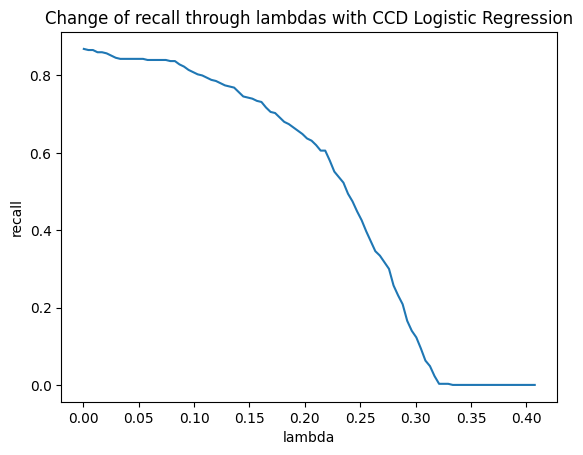

In [3]:
lr_test.plot("recall",X_1,y_1)

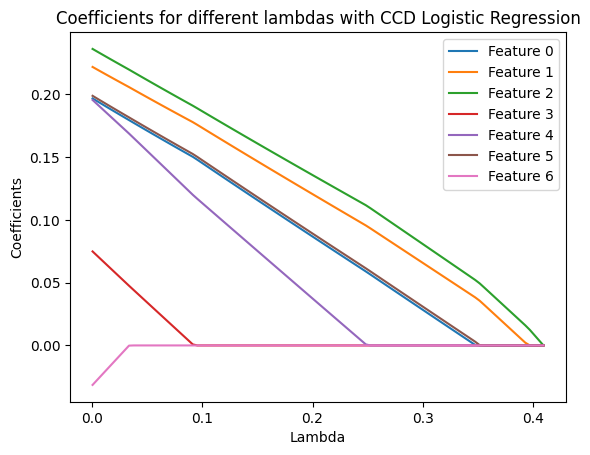

In [4]:
lr_test.plot_coefficients(X_1,y_1)